In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2024-02-25 22:29:06.854319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 22:29:06.854397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 22:29:06.887007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 22:29:06.922743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 22:29:11.945287: W tensorflow/comp

### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_pr = create_predictdand_data(train_files)['pr'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr_truth = Y_test["pr"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr = y_train_pr[~nan_train_mask]
assert len(X_train) == len(y_train_pr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr_truth = pr_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_pr_mean, train_pr_std = y_train_pr.mean(), y_train_pr.std()
y_train_pr = (y_train_pr - train_pr_mean) / train_pr_std

# Scale pr
pr_truth *= 86400

### Prepare model

In [7]:
import gpflow
from gpflow.utilities import to_default_float
from gpflow.optimizers import Scipy
from gpflow.mean_functions import Constant
from gpflow.kernels import Matern52
from gpflow.utilities import print_summary

In [8]:
def create_feature_extractor(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear'),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float64))
    ])
    return model


In [9]:
class DeepKernel(gpflow.kernels.Kernel):
    def __init__(self, feature_extractor, base_kernel, input_dim):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.base_kernel = base_kernel
        self.input_dim = input_dim

    def K(self, X, X2=None):
        # Transform X and X2 using the neural network
        X_transformed = self.feature_extractor(X)
        X2_transformed = self.feature_extractor(X2) if X2 is not None else X2
        # Compute the kernel using the transformed inputs
        return self.base_kernel(X_transformed, X2_transformed)

    def K_diag(self, X):
        X_transformed = self.feature_extractor(X)
        return self.base_kernel.K_diag(X_transformed)


In [10]:
# Define the neural network feature extractor
input_dim = X_train.shape[1]  # Number of features in X
output_dim = 24
feature_extractor = create_feature_extractor(input_dim, output_dim)

# Freeze the neural network layers to make them non-trainable in GPflow's optimization process
for layer in feature_extractor.layers:
    layer.trainable = True

# Define the base kernel and the deep kernel
kernel_CO2 = Matern52(active_dims=[0, 1], variance=1.0, lengthscales=2 * [1.])
kernel_CH4 = Matern52(active_dims=[2, 3], variance=1.0, lengthscales=2 * [1.])
kernel_BC = Matern52(active_dims=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], variance=1.0, lengthscales=10 * [1.])
kernel_SO2 = Matern52(active_dims=[14, 15, 16, 17, 18, 19, 20, 21, 22, 23], variance=1.0, lengthscales=10 * [1.])

kernel_matern12 = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

base_kernel = kernel_matern12
deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

# Mean Function
mean_function = Constant()

# Create the GP model
model = gpflow.models.GPR(data=(X_train.astype(float), y_train_pr.astype(float)), kernel=deep_kernel, mean_function=mean_function)

# Compile the TensorFlow model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = -model.log_marginal_likelihood()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

2024-02-25 22:29:36.645505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


In [11]:
tolerance = 1e-6  # Define tolerance
patience = 10  # Define patience

# Initialize variables for early stopping mechanism
best_loss = float('inf')
patience_counter = 0
max_iterations = 5000

# Training loop
for iteration in range(max_iterations):  # Number of optimization steps
    loss = optimization_step()

    # Early stopping logic
    if best_loss - loss < tolerance:
        patience_counter += 1
    else:
        patience_counter = 0
        best_loss = loss

    if patience_counter >= patience:
        print(f"Stopping training after {iteration + 1} iterations due to convergence.")
        break

2024-02-25 22:29:46.206177: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xc822120
2024-02-25 22:29:46.366472: I external/local_xla/xla/service/service.cc:168] XLA service 0x14fc88b47280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-25 22:29:46.366507: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-02-25 22:29:46.379652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-25 22:29:46.426219: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708925386.536328   50115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Stopping training after 125 iterations due to convergence.


### Predict on testing set

In [12]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

In [13]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])

posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

In [14]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr_truth[35], posterior_pr_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[85], posterior_pr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[30:41], posterior_pr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[75:], posterior_pr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], posterior_pr_data[35:]).mean()}")

RMSE at 2050: 0.4478038612244443
RMSE at 2100: 0.8772120280726621
RMSE 2045-2055: 0.5823030466813263
RMSE 2090-2100: 0.7159557645965705
RMSE 2050-2100: 0.6515989700364182


[Text(0.5, 1.0, 'Difference')]

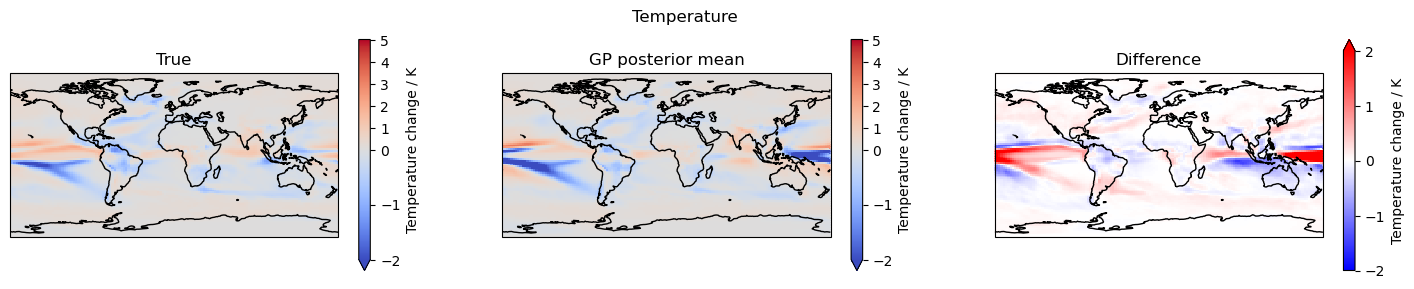

In [15]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - posterior_pr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [16]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

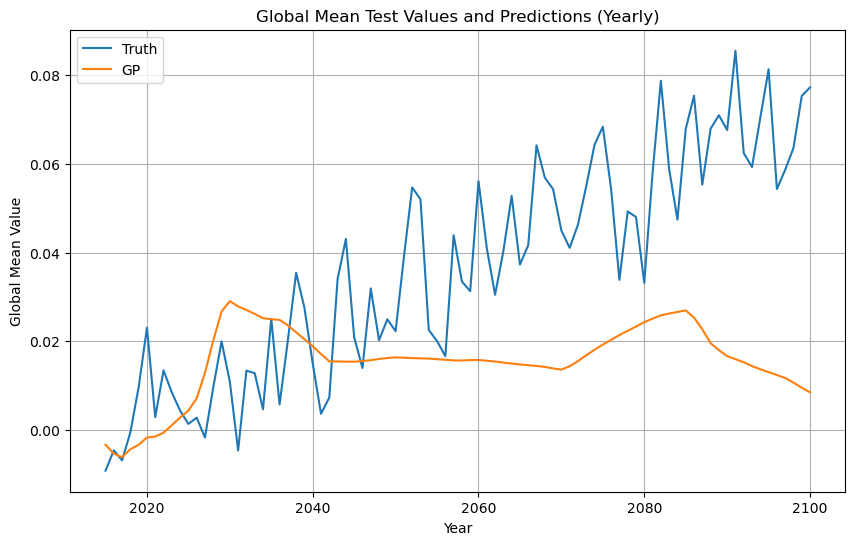

In [17]:
# t = xr.open_dataarray('climatebench-gp-posterior-mean-pr-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(pr_truth).plot(label="Truth")
global_mean(posterior_pr_data).plot(label='GP')
# global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparams Tuning

In [18]:
from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from gpflow.kernels import Matern12, Matern32, Matern52, SquaredExponential, RationalQuadratic, Cosine, Periodic, Polynomial, ArcCosine, Exponential
import keras
import math
from gpflow.mean_functions import Constant
from xskillscore import rmse
from ray.tune import CLIReporter

In [19]:
def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

weights = np.cos(np.deg2rad(pr_truth.lat)).expand_dims(lon=144).assign_coords(lon=pr_truth.lon)
    
def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(3)
    return total

In [20]:
def make_feature_extractor(dim_max, activation, input_dim, output_dim, dropout_prob, bnorm=True, dropout=True):
    model = tf.keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    
    dimensions = [dim_max // (2 ** i) for i in range(int(math.log(dim_max, 2)) + 1) if dim_max // (2 ** i) > input_dim]

    for dim in dimensions[::-1]:
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    for dim in dimensions:
        if dim <= output_dim:
            break
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    model.add(keras.layers.Dense(output_dim, activation='linear'))
    model.add(keras.layers.Lambda(lambda x: tf.cast(x, tf.float64)))
        
    return model

In [21]:
def basekernel(kernel_types, active_dim_multiplier, variance=1.0, lengthscales=1.0):
    kernels = {
        'Matern12': Matern12, 'Matern32': Matern32, 'Matern52': Matern52, 'SquaredExponential': SquaredExponential, 'RationalQuadratic': RationalQuadratic, 'Cosine':Cosine, 'Periodic': Periodic,
        'Polynomial': Polynomial, 'ArcCosine': ArcCosine, 'Exponential': Exponential
    }
    dims = [x for x in range(12*active_dim_multiplier)]
    def CO2(kernel):
        active_dims = dims[0:active_dim_multiplier*1]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k

    def CH4(kernel):
        active_dims = dims[1*active_dim_multiplier:active_dim_multiplier*2]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k
        
    def BC(kernel):
        active_dims = dims[2*active_dim_multiplier:active_dim_multiplier*2 + 5*active_dim_multiplier]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k

    def SO2(kernel):
        active_dims = dims[active_dim_multiplier*2 + 5*active_dim_multiplier:]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k
    
    kernel = CO2(kernels[kernel_types[0]]) + CH4(kernels[kernel_types[1]]) + BC(kernels[kernel_types[2]]) + SO2(kernels[kernel_types[3]])

    return kernel

In [22]:
def objective(config, return_pred=False):  # ①
    input_dim = X_train.shape[1]  # Number of features in X
    
    output_dim = config["output_dim"]
    # Feature extractor for deep kernel
    feature_extractor = make_feature_extractor(
        config["dim_max"], config["activation"], input_dim, config["output_dim"], config["dropout_prob"], bnorm=config["bnorm"], dropout=config["dropout"]
    )
    
    # Freeze the neural network layers to make them non-trainable in GPflow's optimization process
    for layer in feature_extractor.layers:
        layer.trainable = True
    
    # Define kernel
    base_kernel = basekernel(
        config["kernel_types"], config["active_dim_multiplier"]
    )
    deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

    mean_function = Constant() # Define Mean function

    optimizer  = tf.keras.optimizers.Adam(learning_rate=config["optimizer_lr"])# Define opt

    model = gpflow.models.GPR(data=(X_train.astype(float), y_train_pr.astype(float)), kernel=deep_kernel, mean_function=mean_function)
    

    # custom optimizer
    @tf.function
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            loss = -model.log_marginal_likelihood()
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss


    # Training
    tolerance, patience = 1e-6, 10  # Define tolerance and patience

    # Initialize variables for early stopping mechanism
    best_loss, patience_counter, max_iterations = float('inf'), 0, 5000
    
    # Training loop
    for iteration in range(max_iterations):  # Number of optimization steps
        loss = optimization_step()
    
        # Early stopping logic
        if best_loss - loss < tolerance:
            patience_counter += 1
        else:
            patience_counter = 0
            best_loss = loss
    
        if patience_counter >= patience:
            print(f"Stopping training after {iteration + 1} iterations due to convergence.")
            break

    # Eval
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
    posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
    posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])
    
    posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
    posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

    total_NRMSE = TNRMSE(pr_truth, posterior_pr_data)

    if return_pred:
        return posterior_pr_data, posterior_pr_std_data


    return {'nrmse':total_NRMSE}

In [23]:
def run_tuner(search_space, num_samples=50):
    algo = HyperOptSearch()
    
    tuner = tune.Tuner(  # ③
        tune.with_resources(
            objective,
            resources={"cpu": 1, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="nrmse",
            mode="min",
            num_samples=num_samples,
            search_alg=algo,
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    return results

In [24]:
search_space_2 = {
        "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
        "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 512]), 
        "output_dim": tune.choice([36, 48, 60, 72, 84]), "optimizer_lr": tune.choice([0.01, 0.001, 0.0001])
    }  # ②

search_space_1 = {
    "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
    "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52'], 4*['SquaredExponential']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 64]), 
    "output_dim": tune.choice([12, 24, 36, 48, 60]), "optimizer_lr": tune.choice([0.01, 0.001])
} 

run_tuner(search_space_1)

(raylet) Warning: The actor ImplicitFunc is very large (35 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(pid=54547) 2024-02-25 22:30:38.694497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=54547) 2024-02-25 22:30:38.694575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=54547) 2024-02-25 22:30:38.698487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=54547) 2024-02-25 22:30:40.415445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(objective pid=54547) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d06e9d2670> and will run it as-is.
(objective pid=54547) Please repo

(objective pid=54547) Stopping training after 248 iterations due to convergence.


2024-02-25 22:31:08,672	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=54547) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d06d32d160> and will run it as-is.
(objective pid=54547) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=54547) Cause: Unknown node type <gast.gast.Import object at 0x14d0149e10a0>
(objective pid=54547) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=54547) Stopping training after 389 iterations due to convergence.


2024-02-25 22:31:22,269	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=54547) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d01417ed30> and will run it as-is.
(objective pid=54547) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=54547) Cause: Unknown node type <gast.gast.Import object at 0x14cfc29e2910>
(objective pid=54547) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=54547) Stopping training after 145 iterations due to convergence.


2024-02-25 22:31:33,066	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=54547) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d01417ed30> and will run it as-is.
(objective pid=54547) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=54547) Cause: Unknown node type <gast.gast.Import object at 0x14cfa8b99640>
(objective pid=54547) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=54547) Stopping training after 139 iterations due to convergence.


2024-02-25 22:31:44,221	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=54547) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d01417ed30> and will run it as-is.
(objective pid=54547) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=54547) Cause: Unknown node type <gast.gast.Import object at 0x14cfa85d86a0>
(objective pid=54547) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=54547) Stopping training after 85 iterations due to convergence.


2024-02-25 22:31:57,222	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=54547) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14cfa87d05e0> and will run it as-is.
(objective pid=54547) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=54547) Cause: Unknown node type <gast.gast.Import object at 0x14cfa85010a0>
(objective pid=54547) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:32:07,277	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=54547) Stopping training after 122 iterations due to convergence.


(objective pid=54547) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14cfa1fb1280> and will run it as-is.
(objective pid=54547) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=54547) Cause: Unknown node type <gast.gast.Import object at 0x14cfa18f4820>
(objective pid=54547) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:32:21,475	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=54547) Stopping training after 602 iterations due to convergence.


(objective pid=54547) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d06eb36430> and will run it as-is.
(objective pid=54547) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=54547) Cause: Unknown node type <gast.gast.Import object at 0x14cfa131b400>
(objective pid=54547) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=54547) 2024-02-25 22:32:37.424426: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=54547) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=54547) Current allocation summary follows.
(objective pid=54547)

(objective pid=55390) Stopping training after 51 iterations due to convergence.


2024-02-25 22:33:12,682	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=55390) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143a9ce3f430> and will run it as-is.
(objective pid=55390) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=55390) Cause: Unknown node type <gast.gast.Import object at 0x143a9c0c9370>
(objective pid=55390) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:33:21,720	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=55390) Stopping training after 138 iterations due to convergence.


(objective pid=55390) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143af50de1f0> and will run it as-is.
(objective pid=55390) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=55390) Cause: Unknown node type <gast.gast.Import object at 0x143a311bb760>
(objective pid=55390) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=55390) Stopping training after 146 iterations due to convergence.


2024-02-25 22:33:34,320	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=55390) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143a9d0920d0> and will run it as-is.
(objective pid=55390) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=55390) Cause: Unknown node type <gast.gast.Import object at 0x143a30a64c10>
(objective pid=55390) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=55390) Stopping training after 58 iterations due to convergence.


2024-02-25 22:33:44,381	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=55390) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143a9d0920d0> and will run it as-is.
(objective pid=55390) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=55390) Cause: Unknown node type <gast.gast.Import object at 0x143a3091a070>
(objective pid=55390) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=55390) Stopping training after 117 iterations due to convergence.


2024-02-25 22:33:52,969	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=55390) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143a305c25e0> and will run it as-is.
(objective pid=55390) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=55390) Cause: Unknown node type <gast.gast.Import object at 0x143a29e908b0>
(objective pid=55390) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:34:02,951	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=55390) Stopping training after 258 iterations due to convergence.


(objective pid=55390) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143a9d092820> and will run it as-is.
(objective pid=55390) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=55390) Cause: Unknown node type <gast.gast.Import object at 0x143a299333d0>
(objective pid=55390) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:34:24,558	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=55390) Stopping training after 1131 iterations due to convergence.


(objective pid=55390) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x143a3004f280> and will run it as-is.
(objective pid=55390) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=55390) Cause: Unknown node type <gast.gast.Import object at 0x143a29295fd0>
(objective pid=55390) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=55390) 2024-02-25 22:34:39.537187: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=55390) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=55390) Current allocation summary follows.
(objective pid=55390)

(objective pid=56158) Stopping training after 94 iterations due to convergence.


2024-02-25 22:35:12,431	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=56158) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f2b87f430> and will run it as-is.
(objective pid=56158) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56158) Cause: Unknown node type <gast.gast.Import object at 0x144ec41067c0>
(objective pid=56158) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:35:32,029	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=56158) Stopping training after 1015 iterations due to convergence.


(objective pid=56158) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f2b95e700> and will run it as-is.
(objective pid=56158) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56158) Cause: Unknown node type <gast.gast.Import object at 0x144e6408ca60>
(objective pid=56158) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:35:43,184	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=56158) Stopping training after 147 iterations due to convergence.


(objective pid=56158) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144ec4742820> and will run it as-is.
(objective pid=56158) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56158) Cause: Unknown node type <gast.gast.Import object at 0x144f2b7abd30>
(objective pid=56158) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=56158) Stopping training after 585 iterations due to convergence.


2024-02-25 22:35:59,586	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=56158) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f2b7cb430> and will run it as-is.
(objective pid=56158) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56158) Cause: Unknown node type <gast.gast.Import object at 0x144e3dcc2280>
(objective pid=56158) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:36:08,016	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=56158) Stopping training after 75 iterations due to convergence.


(objective pid=56158) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144e3d30a1f0> and will run it as-is.
(objective pid=56158) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56158) Cause: Unknown node type <gast.gast.Import object at 0x144e3dcd8fa0>
(objective pid=56158) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:36:17,568	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=56158) Stopping training after 415 iterations due to convergence.


(objective pid=56158) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144e7c086f70> and will run it as-is.
(objective pid=56158) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56158) Cause: Unknown node type <gast.gast.Import object at 0x144e3c70f0d0>
(objective pid=56158) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:36:26,607	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=56158) Stopping training after 169 iterations due to convergence.


(objective pid=56158) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f2b7cb430> and will run it as-is.
(objective pid=56158) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56158) Cause: Unknown node type <gast.gast.Import object at 0x144e3c1c2520>
(objective pid=56158) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=56158) 2024-02-25 22:36:43.021321: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=56158) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=56158) Current allocation summary follows.
(objective pid=56158)

(objective pid=56919) Stopping training after 78 iterations due to convergence.


2024-02-25 22:37:12,806	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=56919) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x149a7b9ffc10> and will run it as-is.
(objective pid=56919) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56919) Cause: Unknown node type <gast.gast.Import object at 0x149a14130940>
(objective pid=56919) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:37:21,383	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredEx

(objective pid=56919) Stopping training after 135 iterations due to convergence.


(objective pid=56919) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x149a141858b0> and will run it as-is.
(objective pid=56919) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56919) Cause: Unknown node type <gast.gast.Import object at 0x1499cc0e10d0>
(objective pid=56919) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:37:29,985	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=56919) Stopping training after 18 iterations due to convergence.


(objective pid=56919) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x149a14d92f70> and will run it as-is.
(objective pid=56919) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56919) Cause: Unknown node type <gast.gast.Import object at 0x1499b40badc0>
(objective pid=56919) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=56919) Stopping training after 226 iterations due to convergence.


2024-02-25 22:37:41,307	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=56919) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1499c4fc5f70> and will run it as-is.
(objective pid=56919) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56919) Cause: Unknown node type <gast.gast.Import object at 0x149a7bcb2310>
(objective pid=56919) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:37:48,898	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=56919) Stopping training after 77 iterations due to convergence.


(objective pid=56919) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14998dbad430> and will run it as-is.
(objective pid=56919) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56919) Cause: Unknown node type <gast.gast.Import object at 0x149a7bc48970>
(objective pid=56919) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=56919) Stopping training after 59 iterations due to convergence.


2024-02-25 22:37:56,349	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=56919) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14998da7d3a0> and will run it as-is.
(objective pid=56919) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56919) Cause: Unknown node type <gast.gast.Import object at 0x14998d45ae20>
(objective pid=56919) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=56919) Stopping training after 122 iterations due to convergence.


2024-02-25 22:38:04,500	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=56919) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14998d558820> and will run it as-is.
(objective pid=56919) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=56919) Cause: Unknown node type <gast.gast.Import object at 0x14998cbf4700>
(objective pid=56919) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=56919) 2024-02-25 22:38:18.198232: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(ob

(objective pid=57584) Stopping training after 97 iterations due to convergence.


2024-02-25 22:38:45,878	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=57584) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x151221c02940> and will run it as-is.
(objective pid=57584) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=57584) Cause: Unknown node type <gast.gast.Import object at 0x1511c007a730>
(objective pid=57584) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=57584) Stopping training after 443 iterations due to convergence.


2024-02-25 22:38:57,699	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=57584) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15122041b1f0> and will run it as-is.
(objective pid=57584) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=57584) Cause: Unknown node type <gast.gast.Import object at 0x151160be5f40>
(objective pid=57584) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:39:06,181	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=57584) Stopping training after 162 iterations due to convergence.


(objective pid=57584) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15122041b1f0> and will run it as-is.
(objective pid=57584) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=57584) Cause: Unknown node type <gast.gast.Import object at 0x1511600db4f0>
(objective pid=57584) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=57584) Stopping training after 405 iterations due to convergence.


2024-02-25 22:39:17,410	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=57584) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1511c004faf0> and will run it as-is.
(objective pid=57584) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=57584) Cause: Unknown node type <gast.gast.Import object at 0x151159c1bb80>
(objective pid=57584) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:39:25,495	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=57584) Stopping training after 129 iterations due to convergence.


(objective pid=57584) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15116020f550> and will run it as-is.
(objective pid=57584) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=57584) Cause: Unknown node type <gast.gast.Import object at 0x151159704370>
(objective pid=57584) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:39:35,670	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=57584) Stopping training after 337 iterations due to convergence.


(objective pid=57584) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1511c004faf0> and will run it as-is.
(objective pid=57584) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=57584) Cause: Unknown node type <gast.gast.Import object at 0x151159200370>
(objective pid=57584) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:39:44,442	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=57584) Stopping training after 174 iterations due to convergence.


(objective pid=57584) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15115985d9d0> and will run it as-is.
(objective pid=57584) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=57584) Cause: Unknown node type <gast.gast.Import object at 0x151158cd3b20>
(objective pid=57584) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=57584) 2024-02-25 22:39:58.140840: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=57584) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=57584) Current allocation summary follows.
(objective pid=57584)

(objective pid=58257) Stopping training after 137 iterations due to convergence.


2024-02-25 22:40:29,708	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=58257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d550037af0> and will run it as-is.
(objective pid=58257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=58257) Cause: Unknown node type <gast.gast.Import object at 0x14d4841c3520>
(objective pid=58257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:40:40,571	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=58257) Stopping training after 365 iterations due to convergence.


(objective pid=58257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d54be41700> and will run it as-is.
(objective pid=58257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=58257) Cause: Unknown node type <gast.gast.Import object at 0x14d4850bb850>
(objective pid=58257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:40:54,068	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=58257) Stopping training after 659 iterations due to convergence.


(objective pid=58257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d484166160> and will run it as-is.
(objective pid=58257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=58257) Cause: Unknown node type <gast.gast.Import object at 0x14d48451fbb0>
(objective pid=58257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=58257) Stopping training after 157 iterations due to convergence.


2024-02-25 22:41:03,357	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=58257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d484657b80> and will run it as-is.
(objective pid=58257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=58257) Cause: Unknown node type <gast.gast.Import object at 0x14d484380460>
(objective pid=58257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=58257) Stopping training after 1269 iterations due to convergence.


2024-02-25 22:41:22,158	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=58257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d4841979d0> and will run it as-is.
(objective pid=58257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=58257) Cause: Unknown node type <gast.gast.Import object at 0x14d4849250d0>
(objective pid=58257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:41:30,075	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=58257) Stopping training after 98 iterations due to convergence.


(objective pid=58257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d550037af0> and will run it as-is.
(objective pid=58257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=58257) Cause: Unknown node type <gast.gast.Import object at 0x14d465ea9fa0>
(objective pid=58257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:41:38,098	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=58257) Stopping training after 229 iterations due to convergence.


(objective pid=58257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d465a98c10> and will run it as-is.
(objective pid=58257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=58257) Cause: Unknown node type <gast.gast.Import object at 0x14d465277670>
(objective pid=58257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 22:41:53,970	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=58257) Stopping training after 975 iterations due to convergence.


(objective pid=58257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d4652de5e0> and will run it as-is.
(objective pid=58257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=58257) Cause: Unknown node type <gast.gast.Import object at 0x14d464cbe4f0>
(objective pid=58257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=58257) 2024-02-25 22:42:07.870725: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=58257) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=58257) Current allocation summary follows.
(obje

(objective pid=60253) Stopping training after 1073 iterations due to convergence.


2024-02-25 22:42:50,655	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
2024-02-25 22:42:50,701	ERROR tune.py:1038 -- Trials did not complete: [objective_aa70c79c, objective_5c372d68, objective_98992659, objective_49e31fed, objective_22587628, objective_5b6a6f68]
2024-02-25 22:42:50,703	INFO tune.py:1042 -- Total run time: 736.47 seconds (735.73 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'nrmse': 7.691},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-25_22-29-58/objective_5faa97dc_1_activation=relu,active_dim_multiplier=2,bnorm=True,dim_max=128,dropout=True,dropout_prob=0.5000,kernel_types=_2024-02-25_22-30-35',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 10.608},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-25_22-29-58/objective_7eba96de_2_activation=relu,active_dim_multiplier=1,bnorm=True,dim_max=64,dropout=False,dropout_prob=0.5000,kernel_types=_2024-02-25_22-30-47',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 6.076},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-25_22-29-58/objective_374a5ca4_3_activation=tanh,active_dim_multiplier=2,bnorm=True,dim_max=128,dropout=True,dropout_prob=0.5000,kernel_types=_2024-02-25_22-31-09',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 5.059},
    

In [25]:
temp = _.get_dataframe()
best_config = _.get_best_result()

In [28]:
temp.to_csv('model configs and dfs/grid_search_1_pr.csv')

In [39]:
temp_sorted = temp.sort_values(by='nrmse')
temp_sorted_config = temp_sorted[[col for col in temp_sorted.columns if 'config' in col]]

In [49]:
temp_sorted_config.iloc[1]

config/activation                                                sigmoid
config/bnorm                                                       False
config/dropout                                                     False
config/dropout_prob                                                  0.5
config/kernel_types             (Matern32, Matern32, Matern32, Matern32)
config/active_dim_multiplier                                           1
config/dim_max                                                       256
config/output_dim                                                     36
config/optimizer_lr                                                0.001
Name: 37, dtype: object

In [47]:
best_config.config

{'activation': 'relu',
 'bnorm': False,
 'dropout': True,
 'dropout_prob': 0.5,
 'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12'),
 'active_dim_multiplier': 1,
 'dim_max': 256,
 'output_dim': 36,
 'optimizer_lr': 0.001}

In [57]:
t = {
    "activation": "sigmoid", "bnorm": False, "dropout": False, 'dropout_prob': 0.5,
        "kernel_types": 4*['Matern32'], "active_dim_multiplier":1, "dim_max": 256, 
        "output_dim": 36, "optimizer_lr": 0.001
}
mean_best, std_best = objective(t, return_pred=True)

Stopping training after 703 iterations due to convergence.


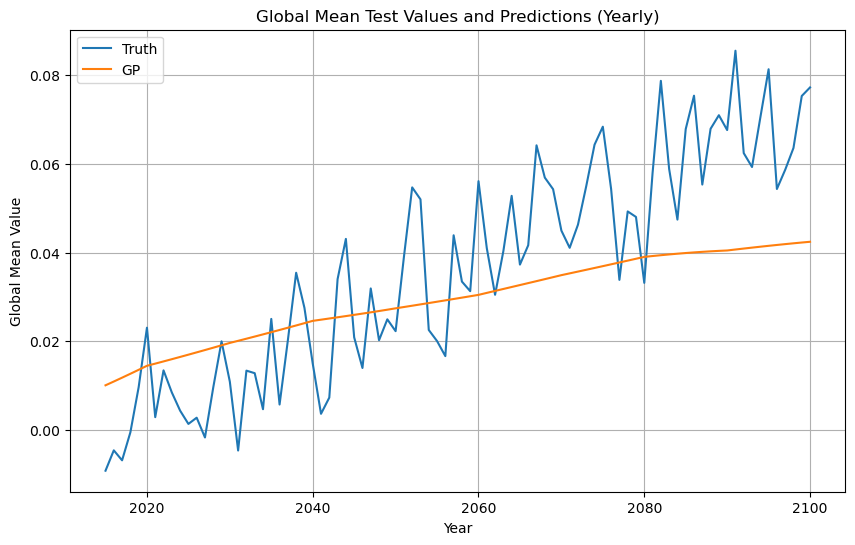

In [58]:
plt.figure(figsize=(10, 6))
global_mean(pr_truth).plot(label="Truth")
global_mean(mean_best).plot(label='GP')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

[Text(0.5, 1.0, 'Difference')]

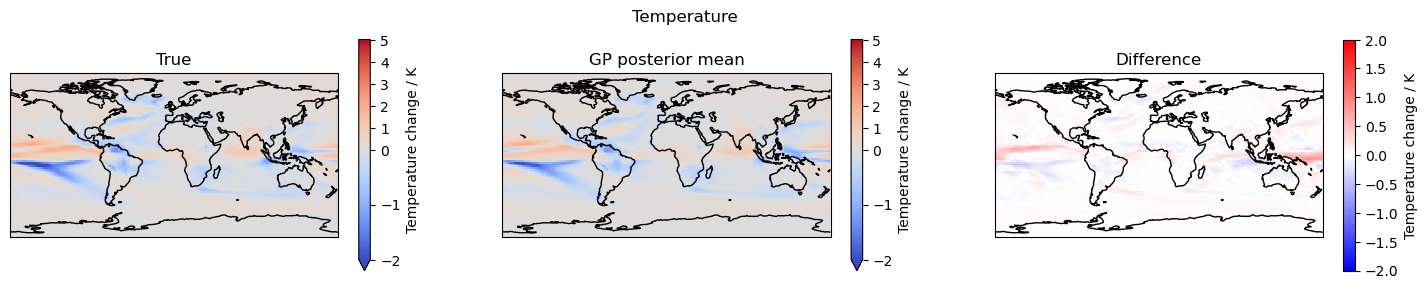

In [59]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mean_best.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - mean_best
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [61]:
mean_best.to_netcdf('model/final-gp-best-model-mean-pr.nc')
std_best.to_netcdf('model/final-gp-best-model-std-pr.nc')